**Models**

**Running Back**

In [152]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [18]:
all_games = pd.read_csv('nfl-football-player-stats/games_1995.csv')
all_games.drop([440917], inplace=True) # delete weird Lagerrete Blount double game
all_games.loc[all_games['team'] == 'SDG', 'team'] = 'LAC'
all_games.loc[all_games['team'] == 'STL', 'team'] = 'LAR'
all_games.loc[all_games['opponent'] == 'SDG', 'opponent'] = 'LAC'
all_games.loc[all_games['opponent'] == 'STL', 'opponent'] = 'LAR'
all_games = all_games.set_index('player_id')
all_players = pd.read_csv('nfl-football-player-stats/players_1995.csv',index_col='player_id')

In [155]:
data = pd.read_csv('rbs_2014_2017.csv', index_col='player_id')
data.head()

,year,game_number,name,team,date,log_draft_position,log_num_games,ewma_fpts,ewma_team_rush_attempts,ewma_team_rush_percentage,ewma_team_passing_rating,ewma_rushing_attempts,ewma_receiving_targets,DY/P,TO,next_fpts,fpts
player_id,,,,,,,,,,,,,,,,,
10,2015,1,Ameer Abdullah,DET,2015-09-13,3.988984,0.000000,17.400000,23.809087,0.517256,84.592646,7.000000,4.000000,5.41250,1.400000,2.3,17.4
10,2015,2,Ameer Abdullah,DET,2015-09-20,3.988984,0.693147,9.378125,22.890371,0.495618,84.005276,6.468750,2.406250,4.47098,1.750000,11.2,2.3
10,2015,3,Ameer Abdullah,DET,2015-09-27,3.988984,1.098612,10.062809,22.432680,0.482016,82.887008,7.044213,3.381014,4.53456,1.666667,5.4,11.2
10,2015,4,Ameer Abdullah,DET,2015-10-05,3.988984,1.386294,8.670033,21.911188,0.475728,82.947360,8.823200,3.864604,5.47330,2.000000,3.0,5.4
10,2015,5,Ameer Abdullah,DET,2015-10-11,3.988984,1.609438,7.236029,21.451048,0.455653,81.059436,8.109187,3.393028,5.46972,1.750000,8.4,3.0


In [192]:
# Tuning parameter for RF
# 350 is best
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=3)

#get 2014-2016
features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','ewma_receiving_targets','DY/P','TO']
resp = ['next_fpts']
trainX2016 = data.loc[data['year'] < 2017][features]
trainy2016 = data.loc[data['year'] < 2017][resp]

# re index
trainX2016.reset_index(drop=True, inplace=True)
trainy2016.reset_index(drop=True, inplace=True)

range_est = [200,250,300,350,400]
mses = [0,0,0,0,0]
maes = [0,0,0,0,0]

for train_index, test_index in kf.split(trainX2016):
    X_train, X_test = trainX2016.iloc[train_index], trainX2016.iloc[test_index]
    y_train, y_test = trainy2016.iloc[train_index], trainy2016.iloc[test_index]
    for j in range(len(range_est)):
        rf_model = RandomForestRegressor(n_estimators=range_est[j])
        rf_model.fit(X_train, y_train)
        preds = rf_model.predict(X_test)
        mses[j] += mean_squared_error(y_test, preds)
        maes[j] += mean_absolute_error(y_test, preds)
print(mses)
print(maes)

C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vec

[248.94370584752178, 249.62279095060796, 249.4531674369507, 248.54344858429192, 248.57263274438387]
[27.555351744162273, 27.59548383102278, 27.560297992066413, 27.572680811586075, 27.54685355273382]


In [178]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Training on the 2017 season
MSEarma = []
MAEarma = []
MSElr = []
MAElr = []
MSErf = []
MAErf = []
MSEbase = []
MAEbase = []

for w in range(1,11):
    print(w)
    WEEK = w
    POSITION = 'RB'
    YEAR = 2017

    features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','ewma_receiving_targets','DY/P','TO']
    resp = ['next_fpts']
    X_train = data.loc[data['year'] < 2017][features]
    X_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][features]
    if len(X_traincurr)>0:
        X_train = X_train.append(X_traincurr)
    y_train = data.loc[data['year'] < 2017][resp]
    y_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][resp]
    if len(y_traincurr)>0:
        y_train = y_train.append(y_traincurr) 
    X_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][features]
    y_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][resp]

    # Fitting models

    # naive approach
    preds = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)]['fpts']
    MAEbase.append(mean_absolute_error(y_test, preds))
    MSEbase.append(mean_squared_error(y_test, preds))

    # ARMA
    '''
    players = get_players_thatweek(all_games, all_players, POSITION, YEAR, WEEK, subset_position)
    X, resp = get_features_response_ARMA(players, all_games, YEAR, WEEK, half_ppr)
    preds = []
    for i in resp.index:
        if type(X.loc[i]['fpts']) != np.float64:
            past_fpts = X.loc[i]['fpts'].values
            model = ARMA(past_fpts, (0,1))
            model_fit = model.fit(disp=0)
            preds.append(model_fit.forecast()[0][0])
        else:
            resp.drop([i],inplace=True)
    MAEarma.append(mean_absolute_error(resp, preds))
    MSEarma.append(mean_squared_error(resp, preds))
    '''

    # linear regression
    XtrainS = StandardScaler().fit_transform(X_train)
    XtestS = StandardScaler().fit_transform(X_test)
    lr = LinearRegression()
    lr.fit(XtrainS, y_train)
    preds = lr.predict(XtestS)
    MAElr.append(mean_absolute_error(y_test, preds))
    MSElr.append(mean_squared_error(y_test, preds))

    # random forest
    rf = RandomForestRegressor(n_estimators = 350)
    rf.fit(XtrainS, y_train)
    preds = rf.predict(XtestS)
    MAErf.append(mean_absolute_error(y_test, preds))
    MSErf.append(mean_squared_error(y_test, preds))

1


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


4


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


7


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


8


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


9


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


10


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [179]:
lr.score(XtestS, y_test)

0.1491566884818184

In [180]:
print("RF: ",MAErf)
print("RF: ", MSErf)
print("LR: ",MAElr)
print("LR: ", MSElr)
print("baseline: ",MAEbase)
print("baseline: ", MSEbase)
print("ARMA: ",MAEarma)
print('ARMA: ', MSEarma)

RF:  [5.636448979591836, 5.521327188940092, 6.181046004842615, 4.774733333333334, 5.3210444964871195, 4.874350877192982, 4.784980952380953, 5.827625615763546, 5.236643990929702, 4.964153846153845]
RF:  [46.255478270165206, 51.48887158920344, 59.598065533033534, 41.546498881632644, 45.804967227835405, 34.537347908342284, 34.52722476734696, 50.786717106263204, 39.0002787482993, 43.16183732119308]
LR:  [5.3036770344002155, 5.0545359241900405, 5.886188555618626, 4.577816394368309, 5.1679937634685, 4.7438467969241955, 4.852081655855222, 5.694446144607861, 5.014576370865819, 4.929484224734537]
LR:  [43.78875939387488, 46.055711599091765, 55.69817663557197, 38.08968774577928, 45.023267599593524, 31.5990094817023, 36.29342157885604, 49.65276254142676, 34.11679987383564, 41.02784572613581]
baseline:  [5.980952380952382, 5.829032258064516, 6.552542372881358, 6.734999999999999, 5.413114754098362, 5.9515789473684215, 6.316666666666666, 6.620689655172414, 6.260317460317461, 6.212307692307692]
basel

Plot

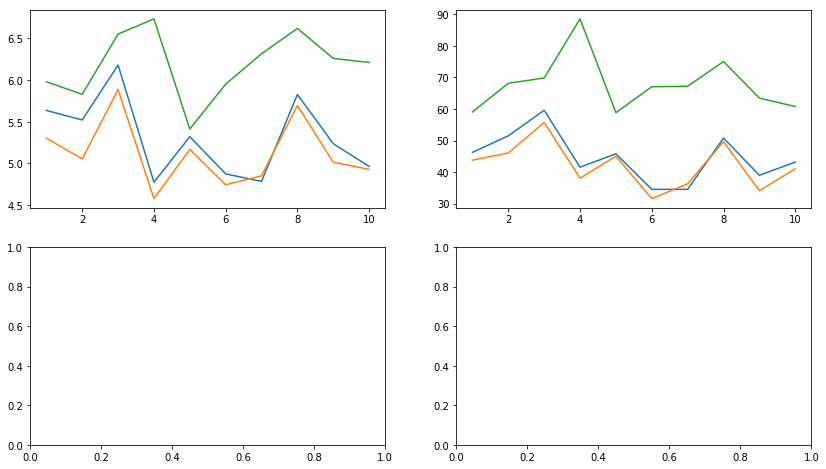

In [189]:
fig, axs = plt.subplots(2,2, figsize=(14,8))
weeks = range(1,11)
axs[0,0].plot(weeks, MAErf)
axs[0,0].plot(weeks, MAElr)
axs[0,0].plot(weeks, MAEbase)
axs[0,1].plot(weeks, MSErf)
axs[0,1].plot(weeks, MSElr)
axs[0,1].plot(weeks, MSEbase)

Helpful Functions

In [17]:
def get_players_thatweek(all_games, all_players, position, year, game_number, subset_position, specific_players=None):
    if specific_players != None:
        ids = specific_players
    else:
        ids = all_players[all_players.position == position].index
        
    # return pandas df with player_id as index and player name and log draft position columns
    games = all_games.loc[ids]
    stats = subset_position[position][0]
    sum_threshold = subset_position[position][1]
    # only take RBs with 5 rush attempts or receiving targets (>= sum_threshold)
    worth_predicting = games[(games.year == year) & 
                             (games.game_number == game_number) &
                             (np.sum(games[stats], axis=1) >= sum_threshold)]
    ids = worth_predicting.index
    for_df = all_players.loc[ids, ['name', 'draft_position']]
    # players that weren't drafted give them position of last pick of draft
    for_df.fillna(255, inplace=True)
    for_df['log_draft_position'] = np.log(for_df.draft_position)
    return pd.DataFrame(data=for_df)

In [20]:
half_ppr = {
    'rushing_yards': 0.1,
    'rushing_touchdowns': 6,
    'receiving_receptions': 0.5,
    'receiving_yards': 0.1,
    'receiving_touchdowns': 6
}

In [190]:
# subset RB position by choosing only RBs with at least 3 fantasy points in previous game
subset_position = {
    'RB': [['rushing_attempts', 'receiving_targets'], 5.0],
    'WR': [['rushing_attempts', 'receiving_targets'], 5.0],
    'QB': [['passing_attempts'], 10.0]
}

In [43]:
def get_features_response_ARMA(players, all_games, year, gameNumber, points_dict):
    games = all_games.loc[players.index]
    
    # compute fpts for each row
    games['fpts'] = games['game_number']*0
    for stat, value in zip(points_dict.keys(), points_dict.values()):
        games['fpts'] = games['fpts'] + games[stat]*value

    prev_years = games[(games.year < year) &
                       (games.game_number <= 16)]
    current_year = games[(games.year == year) &
                         (games.game_number <= gameNumber)]
    next_game = games[(games.year == year) &
                     (games.game_number == gameNumber+1)]
    
    df = pd.concat((prev_years, current_year))
    df.sort_values(by=['player_id', 'year', 'game_number'], axis=0,
                   ascending=False, inplace=True)
    # group dataframe by index
    df = df.groupby(df.index)
    
    past_16 = df.nth(list(range(0,16))).fpts
    weeks = df.nth(list(range(0,16))).game_number
    years = df.nth(list(range(0,16))).year
    
    # get response variable, the next game fantasy points 
    resp = next_game['fpts']

    for_return = pd.concat([past_16, years, weeks], axis=1)
    for_return.sort_values(by=['player_id', 'year', 'game_number'], axis=0, ascending=False, inplace=True)
    resp = resp.sort_index(ascending=False)
    return for_return, resp